In [1]:
# === 📦 Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# === 📥 Load Dataset ===
data = pd.read_csv("/content/Heart_Disease_Prediction.csv")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [3]:
# === 🧹 Data Preprocessing ===
# Hapus duplikat
data.drop_duplicates(inplace=True)

# Konversi label target ke numerik
data['Heart Disease'] = data['Heart Disease'].replace({'Absence': 0, 'Presence': 1})

# Pisahkan fitur dan label
X = data.drop('Heart Disease', axis=1)
y = data['Heart Disease']

# Normalisasi fitur numerik
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Ukuran data latih:", X_train.shape)
print("Ukuran data uji:", X_test.shape)

Ukuran data latih: (216, 13)
Ukuran data uji: (54, 13)


<ipython-input-3-3759464943>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Heart Disease'] = data['Heart Disease'].replace({'Absence': 0, 'Presence': 1})


In [4]:

# === 🔁 SMOTE-Tomek Balancing ===
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

# Cek distribusi label setelah balancing
print("Distribusi label setelah SMOTE-Tomek:")
print(pd.Series(y_train).value_counts())


Distribusi label setelah SMOTE-Tomek:
Heart Disease
0    110
1    110
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parameter grid yang akan diuji
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inisialisasi model dasar
rf_base = RandomForestClassifier(random_state=42)

# GridSearchCV dengan 5-fold cross validation
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# Fit ke data latih hasil SMOTE
grid_search.fit(X_train, y_train)

# Model terbaik dan skor terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

# Simpan model terbaik
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validated Accuracy: 0.9


In [6]:
# === 🤖 Model Training ===
# k-NN
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

# Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [7]:
# === 📊 Evaluation Metrics ===
# Evaluasi semua model
print("k-NN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("k-NN F1 Score:", f1_score(y_test, y_pred_knn))
print("k-NN Precision:", precision_score(y_test, y_pred_knn))
print("k-NN Recall:", recall_score(y_test, y_pred_knn))

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree F1 Score:", f1_score(y_test, y_pred_dt))
print("Decision tree Precision:", precision_score(y_test, y_pred_dt))
print("Decision Tree Recall:", recall_score(y_test, y_pred_dt))

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf))
print("Random Forest Precision:", precision_score(y_test, y_pred_rf))
print("Random Forest Recall:", recall_score(y_test, y_pred_rf))

k-NN Accuracy: 0.7592592592592593
k-NN F1 Score: 0.7547169811320755
k-NN Precision: 0.6896551724137931
k-NN Recall: 0.8333333333333334
Decision Tree Accuracy: 0.7592592592592593
Decision Tree F1 Score: 0.7450980392156863
Decision tree Precision: 0.7037037037037037
Decision Tree Recall: 0.7916666666666666
Random Forest Accuracy: 0.7962962962962963
Random Forest F1 Score: 0.7755102040816326
Random Forest Precision: 0.76
Random Forest Recall: 0.7916666666666666


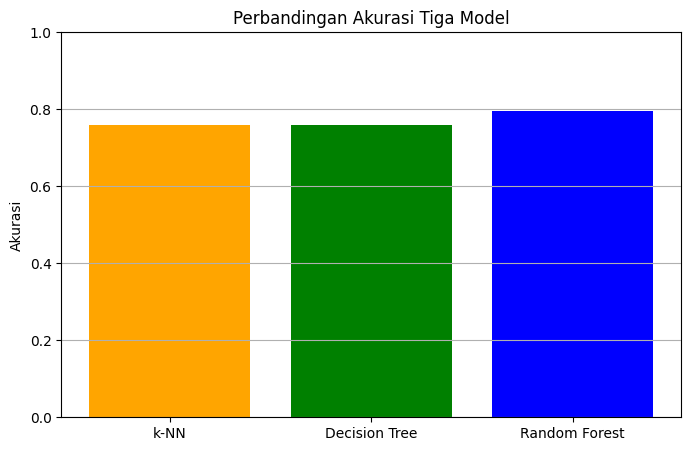

In [8]:
# 🔢 Nilai Akurasi Tiap Model
accuracy_scores = [
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_rf)
]

models = ['k-NN', 'Decision Tree', 'Random Forest']

# 📊 Visualisasi Perbandingan Akurasi
plt.figure(figsize=(8, 5))
plt.bar(models, accuracy_scores, color=['orange', 'green', 'blue'])
plt.title("Perbandingan Akurasi Tiga Model")
plt.ylabel("Akurasi")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


<ipython-input-9-2526636824>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


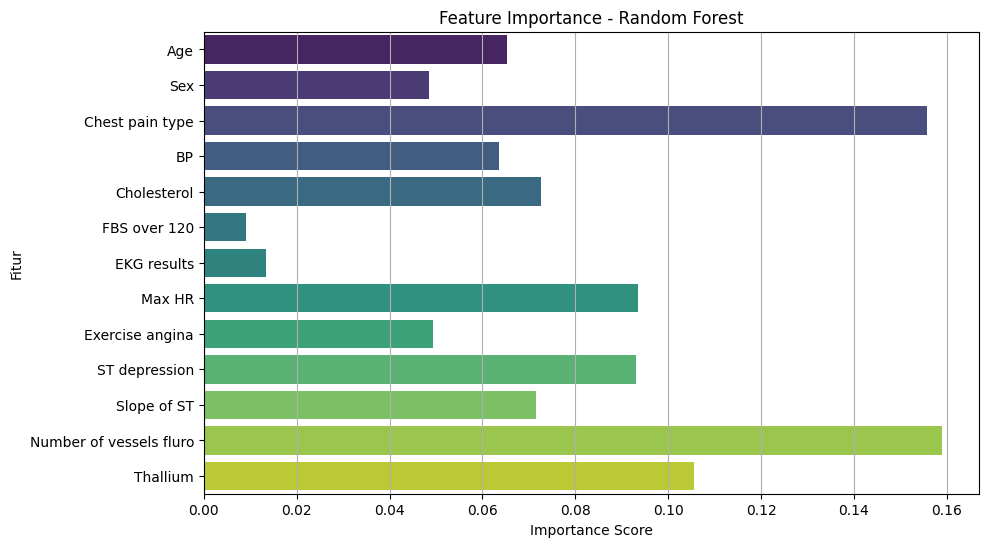

In [9]:
# 🔍 Feature Importance dari Random Forest
importances = model_rf.feature_importances_
feature_names = data.drop('Heart Disease', axis=1).columns

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Fitur")
plt.grid(axis='x')
plt.show()

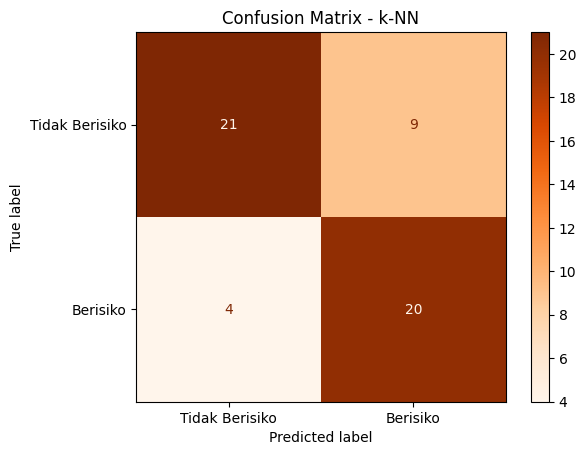

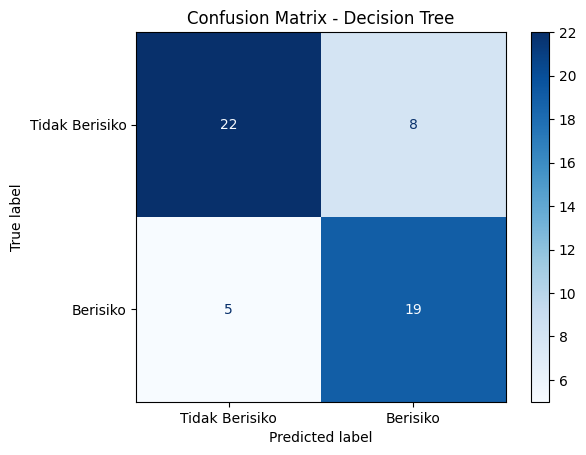

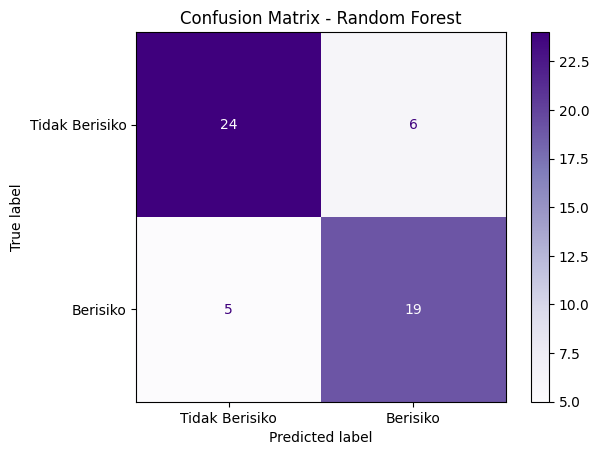

In [10]:
# === 📈 Confusion Matrix ===
# k-NN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Tidak Berisiko", "Berisiko"])
disp_knn.plot(cmap='Oranges')
plt.title("Confusion Matrix - k-NN")
plt.show()

# Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Tidak Berisiko", "Berisiko"])
disp_dt.plot(cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Tidak Berisiko", "Berisiko"])
disp_rf.plot(cmap='Purples')
plt.title("Confusion Matrix - Random Forest")
plt.show()

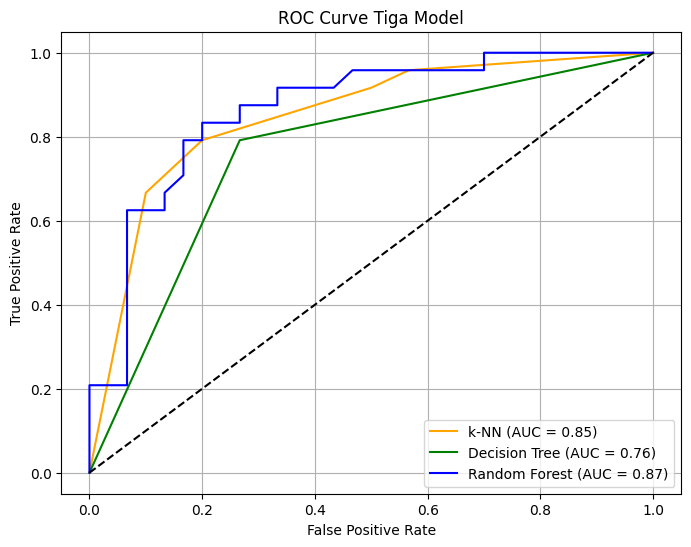

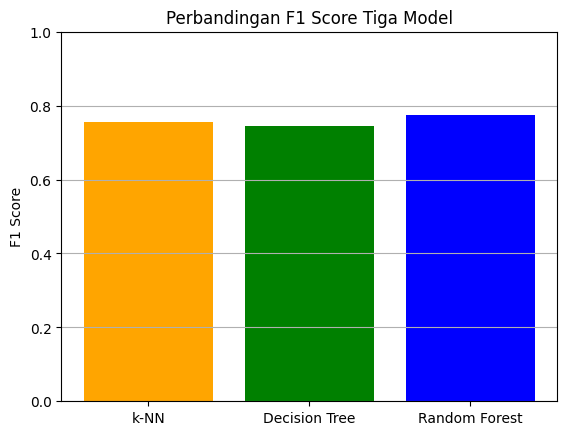

In [11]:
# === 📉 ROC Curve & F1 Chart ===
# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, model_knn.predict_proba(X_test)[:, 1])
fpr_dt, tpr_dt, _ = roc_curve(y_test, model_dt.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8,6))
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {auc(fpr_knn, tpr_knn):.2f})', color='orange')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc(fpr_dt, tpr_dt):.2f})', color='green')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Tiga Model")
plt.legend()
plt.grid()
plt.show()

# F1 Score Bar Plot
models = ['k-NN', 'Decision Tree', 'Random Forest']
f1_scores = [
    f1_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_dt),
    f1_score(y_test, y_pred_rf)
]

plt.bar(models, f1_scores, color=['orange', 'green', 'blue'])
plt.title("Perbandingan F1 Score Tiga Model")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

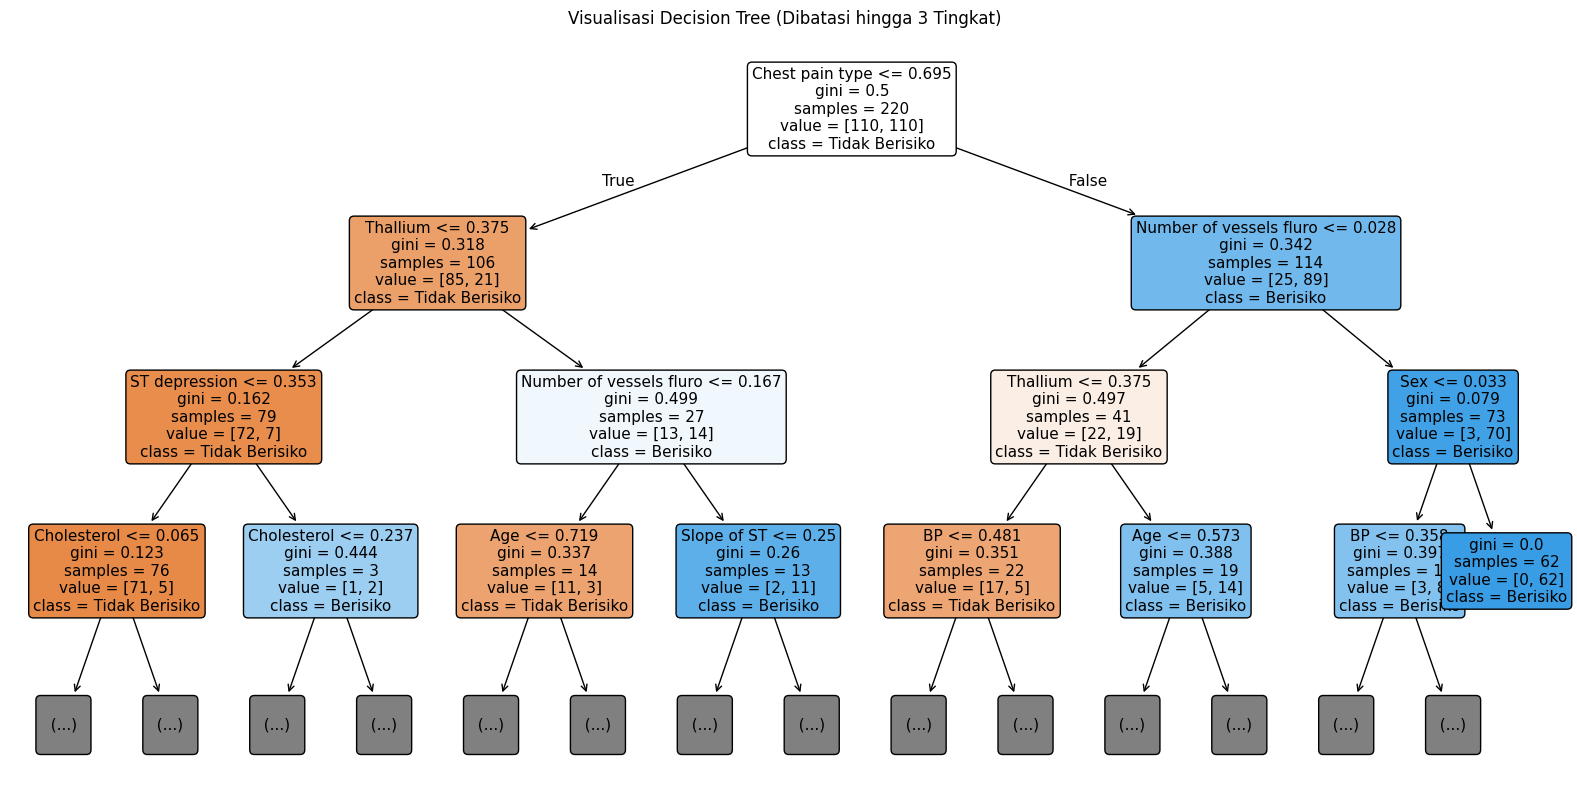

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  # Besarkan ukuran kanvas
plot_tree(
    model_dt,
    feature_names=X.columns,
    class_names=["Tidak Berisiko", "Berisiko"],
    filled=True,
    rounded=True,
    max_depth=3,      # ✅ Batasi kedalaman pohon
    fontsize=11
)
plt.title("Visualisasi Decision Tree (Dibatasi hingga 3 Tingkat)")
plt.show()
